In [21]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [22]:
import os
import cv2

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.layers as tfl
import tensorflow_addons as tfa

AUTOTUNE = tf.data.experimental.AUTOTUNE

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import image as Image

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

from kaggle_datasets import KaggleDatasets
import warnings
warnings.simplefilter('ignore')

Device: 
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: local


INFO:tensorflow:Initializing the TPU system: local


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


Number of replicas: 8


# Exploratory Data Analysis

This Monet dataset has already been cleaned and we can safely assume the Monet images under the Monet folders are actually Monet images and not falsely identified.

We will load the datasets and perform basic EDA by looking through the images and getting a sense of what they look like.

In [23]:
path = KaggleDatasets().get_gcs_path()
path

get_gcs_path is not required on TPU VMs which can directly use Kaggle datasets, using path: /kaggle/input/gan-getting-started


'/kaggle/input/gan-getting-started'

In [24]:
# Look at tfrec type files
monet_filenames = tf.io.gfile.glob(str(path + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(monet_filenames))

photo_filenames = tf.io.gfile.glob(str(path + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(monet_filenames))

Monet TFRecord Files: 5
Photo TFRecord Files: 5


(256, 256, 3)


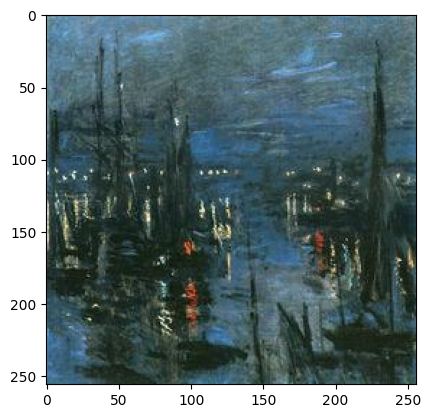

In [25]:
# Look at sample Monet jpeg image
#We have been given .tfrec files and jpeg, for the project we will use .tfrec files

image_monet = Image.imread('/kaggle/input/gan-getting-started/monet_jpg/058f878b7c.jpg')
print(image_monet.shape)
plt.imshow(image_monet)
plt.show()

(256, 256, 3)


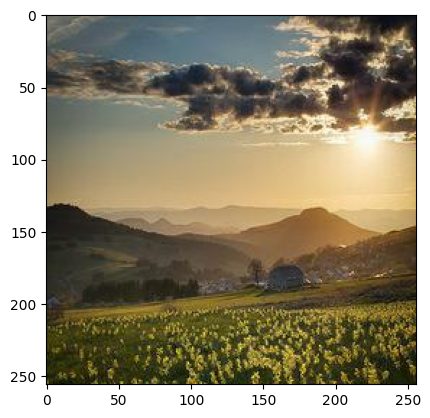

In [26]:
# Look at non-Monet jpeg image

image_non = Image.imread('/kaggle/input/gan-getting-started/photo_jpg/00068bc07f.jpg')
print(image_non.shape)
plt.imshow(image_non)
plt.show()


We can see the difference between a Monet image and a normal camera image, as the Monet image clearly looks painted. I plan to create a CycleGAN which will modify the non-Monet images into Monet images. This will make normal photos look like fake Monet paintings, which should be fun to produce.

In [27]:
monet_jpg_filepath = "../input/gan-getting-started/monet_jpg"
photo_jpg_filepath = "../input/gan-getting-started/photo_jpg"

monet_image_paths = []
for dirname, _, filenames in os.walk(monet_jpg_filepath):
    for filename in filenames:
        fullpath = os.path.join(dirname, filename)
        monet_image_paths.append(fullpath)

        

non_monet_image_paths = []
for dirname, _, filenames in os.walk(photo_jpg_filepath):
    for filename in filenames:
        fullpath = os.path.join(dirname, filename)
        non_monet_image_paths.append(fullpath)


In [28]:
monet_image_paths[:5]

['../input/gan-getting-started/monet_jpg/f4413e97bd.jpg',
 '../input/gan-getting-started/monet_jpg/7341d96c1d.jpg',
 '../input/gan-getting-started/monet_jpg/de6f71b00f.jpg',
 '../input/gan-getting-started/monet_jpg/99d94af5dd.jpg',
 '../input/gan-getting-started/monet_jpg/99a51d3e25.jpg']

In [29]:
non_monet_image_paths[:5]

['../input/gan-getting-started/photo_jpg/fb97febc5f.jpg',
 '../input/gan-getting-started/photo_jpg/c54c5368af.jpg',
 '../input/gan-getting-started/photo_jpg/4a06596662.jpg',
 '../input/gan-getting-started/photo_jpg/2629524a69.jpg',
 '../input/gan-getting-started/photo_jpg/5e64b64de8.jpg']

In [30]:
print('Number of Monet Images:', len(monet_image_paths))

Number of Monet Images: 300


In [31]:
print('Number of non Monet Images:', len(non_monet_image_paths))

Number of non Monet Images: 7038


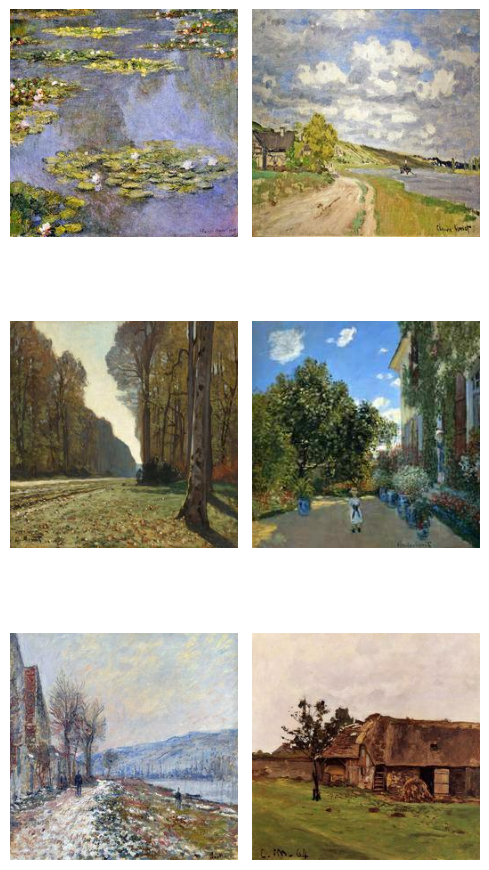

In [32]:
figure, ax = plt.subplots(nrows = 3,ncols = 2,figsize=(5,10))
for i, image_path in enumerate(monet_image_paths):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    try:
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    except:
        continue;
        
plt.tight_layout()
plt.show()

Above, I am displaying sample Monet images which look beautiful. I am going to compare this to samples of non-Monet images below.

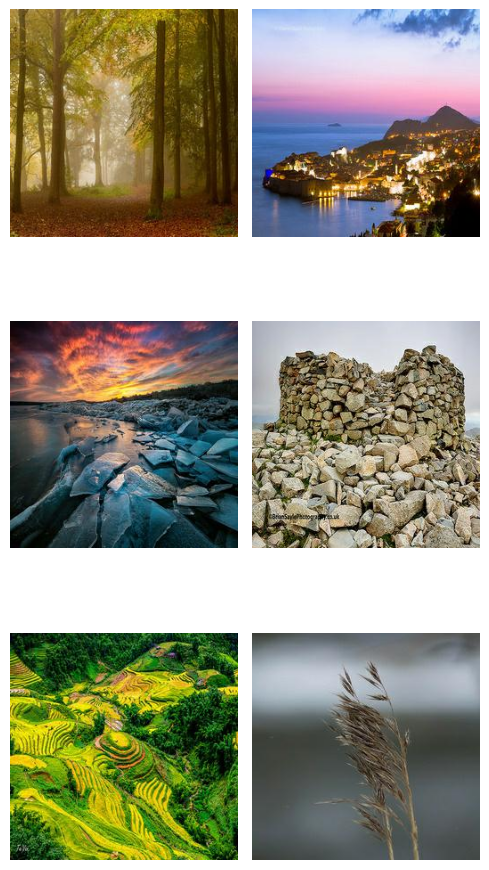

In [33]:

figure, ax = plt.subplots(nrows = 3,ncols = 2,figsize=(5,10))
for i, image_path in enumerate(non_monet_image_paths):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    try:
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    except:
        continue;
        
plt.tight_layout()
plt.show()



Though both sets of images, Monet and non-Monet, are both beautiful, the purpose of exploring this data was to get a sense of how the Monet images clearly look like paintings whereas the non-Monet images are photos of nature and are crisp and sharp, unlike a painting. Our job is to now convert and try to update some of these other photos to look like Monet images.

# Model Building

In this section, we'll design a U-Net Architecture specifically tailored for the CycleGAN. U-Net, initially developed for medical applications, has gained popularity in various domains, particularly for semantic segmentation in deep learning.

Our approach involves creating downsample and upsample layers for the CycleGAN. In the upsampling process, Conv2D transpose layers will be employed to increase both height and width, reaching the desired shape. Conversely, in the downsampling phase, we'll utilize stride operations to decrease both height and width.

An alteration in our approach includes opting for instance normalization over batch normalization. This modification aligns with a common trend observed in many notebooks, where instance normalization is favored over the traditional BatchNormalization layer. We will incorporate this into our model.

In [34]:
image_size = [256, 256]

# to read from tfrec
def decode_image(image_data):
    decoded_image = tf.image.decode_jpeg(image_data, channels=3)
    normalized_image = (tf.cast(decoded_image, tf.float32) / 127.5) - 1
    reshaped_image = tf.reshape(normalized_image, [*image_size, 3])
    return reshaped_image


def read_tfrecord(tfrecord_example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    parsed_example = tf.io.parse_single_example(tfrecord_example, tfrecord_format)
    decoded_image = decode_image(parsed_example['image'])
    return decoded_image


In [35]:
# In this section, we're loading the dataset and utilizing Autotune for more efficient batch dataset retrieval

def load_dataset(file_names, labeled=True, ordered=False):
    data_set = tf.data.TFRecordDataset(file_names)
    data_set = data_set.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return data_set

monet_dataset = load_dataset(monet_filenames, labeled=True).batch(1)
photo_dataset = load_dataset(photo_filenames, labeled=True).batch(1)

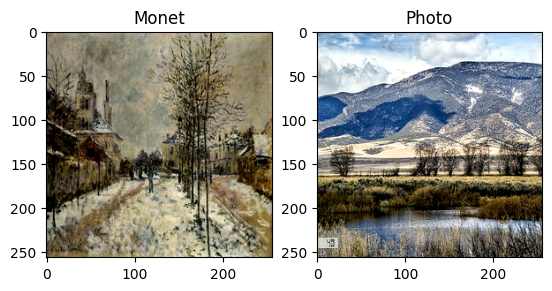

In [36]:
plt.subplot(121)
plt.title('Monet')
plt.imshow(next(iter(monet_dataset))[0] * 0.6 + 0.5)

plt.subplot(122)
plt.title('Photo')
plt.imshow(next(iter(photo_dataset))[0] * 0.6 + 0.5)

The batching process is functioning correctly, evident from the correct loading of images above. Subsequently, we will create functions for downsampling and upsampling, each of which will produce sequential models.The discriminator loss function provided below contrasts real images with a matrix of 1s and fake images with a matrix of 0s. An ideal discriminator would yield all 1s for real images and all 0s for fake ones. The discriminator loss computes the average of the losses for real and generated images.

In [37]:
output_channels = 3

# For downsampling, Conv2D is employed to decrease the image size

def downsample(filters, size, use_instance_norm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    model = keras.Sequential()
    model.add(tfl.Conv2D(filters=filters, kernel_size=size, strides=2, padding='same',
                         kernel_initializer=initializer, use_bias=False))

    if use_instance_norm:
        model.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    model.add(tfl.LeakyReLU())

    return model


# For upsampling, Conv2DTranspose is utilized to enlarge the image, and a stride of 2 is applied to double the dimensions

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    model = keras.Sequential()
    model.add(tfl.Conv2DTranspose(filters=filters, kernel_size=size, strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  use_bias=False))

    model.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        model.add(tfl.Dropout(0.5))

    model.add(tfl.ReLU())

    return model



In [38]:
def Generator():
    input_shape = [256, 256, 3]
    inputs = tfl.Input(shape=input_shape)

    down_stack = [
        downsample(filters=64, size=4, use_instance_norm=False),  # Each Downstack layer has a stride of 2
        downsample(filters=128, size=4),
        downsample(filters=256, size=4),
        downsample(filters=512, size=4),
        downsample(filters=512, size=4),
        downsample(filters=512, size=4),
        downsample(filters=512, size=4),
        downsample(filters=512, size=4),
    ]

    up_stack = [
        upsample(filters=512, size=4, apply_dropout=True),  # (bs, 2, 2, 1024)
        upsample(filters=512, size=4, apply_dropout=True),  # (bs, 4, 4, 1024)
        upsample(filters=512, size=4, apply_dropout=True),  # (bs, 8, 8, 1024)
        upsample(filters=512, size=4),  # (bs, 16, 16, 1024)
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last_layer = tfl.Conv2DTranspose(output_channels, kernel_size=4, strides=2, padding='same',
                                     kernel_initializer=initializer,
                                     activation='tanh')

    x = inputs

    # Downsampling through the model
    skips = []
    for down_layer in down_stack:
        x = down_layer(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tfl.Concatenate()([x, skip])

    x = last_layer(x)

    return keras.Model(inputs=inputs, outputs=x)


In [39]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    input_shape = [256, 256, 3]
    x = tfl.Input(shape=input_shape)

    # Down layers consist of Conv2D layers with their own initializers and LeakyReLU activation

    down_layer_1 = downsample(filters=64, size=4, use_instance_norm=False)(x)
    down_layer_2 = downsample(filters=128, size=4)(down_layer_1)
    down_layer_3 = downsample(filters=256, size=4)(down_layer_2)

    zero_pad1 = tfl.ZeroPadding2D(padding=2)(down_layer_3)
    conv_layer_1 = tfl.Conv2D(filters=512, kernel_size=4, strides=2,
                              kernel_initializer=initializer, use_bias=False)(zero_pad1)

    norm_1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv_layer_1)

    leaky_relu_1 = tfl.LeakyReLU()(norm_1)

    zero_pad2 = tfl.ZeroPadding2D()(leaky_relu_1)

    last_layer = tfl.Conv2D(filters=1, kernel_size=4, strides=1,
                            kernel_initializer=initializer)(zero_pad2)

    return keras.Model(inputs=x, outputs=last_layer)


In [40]:
with strategy.scope():
    monet_generator = Generator()  # Generates Monet-esque paintings from photos
    photo_generator = Generator()  # Enhances Monet paintings to resemble photos more closely

    monet_discriminator = Discriminator()  # Discriminates between real Monet paintings and generated Monet-style paintings
    photo_discriminator = Discriminator()  # Discriminates between real photos and generated photos


2023-12-11 03:24:56.513865: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-11 03:24:56.969978: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


In [41]:
# The CycleGAN class is adapted/imported from the Kaggle Tutorial notebook
# Link: https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook#Build-the-generator

class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # Photo to Monet back to Photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # Monet to Photo back to Monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # Generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # Discriminator used to check, inputting real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # Discriminator used to check, inputting fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # Evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # Evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # Evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # Evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss, self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss, self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss, self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss, self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients, self.m_gen.trainable_variables))
        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients, self.p_gen.trainable_variables))
        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients, self.m_disc.trainable_variables))
        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients, self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }


The discriminator loss function provided below contrasts real images with a matrix of 1s and fake images with a matrix of 0s. An ideal discriminator would yield all 1s for real images and all 0s for fake ones. The discriminator loss computes the average of the losses for real and generated images.

In [42]:
with strategy.scope():
    def discriminator_loss(real, generated):
        
        cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True, 
                                                           reduction=tf.keras.losses.Reduction.NONE)
        
        # The discriminator loss consists of two components: 
        # the first part involves identifying real images as real, 
        # and the second part aims to minimize identifying generated images as real.
        
        real_loss = cross_entropy(tf.ones_like(real), real)
        fake_loss = cross_entropy(tf.zeros_like(generated), generated)

        total_loss = real_loss + fake_loss

        return total_loss * 0.5


The goal of the generator is to deceive the discriminator into perceiving the artificially generated image as real. An ideal generator would prompt the discriminator to produce only 1s. Consequently, it assesses the loss by contrasting the generated image with a matrix of 1s.

In [43]:
with strategy.scope():
    def generator_loss(generated):
        
        cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True, 
                                                           reduction = tf.keras.losses.Reduction.NONE)
        #For generator we have only one term for loss
        
        return cross_entropy(tf.ones_like(generated), generated)

Given our utilization of CycleGAN, we need to incorporate specific losses tailored to it.

Our objective is to ensure that the original photo and the photo subjected to double transformations exhibit similarity. The Cycle Loss, in this context, is computed as the average of the differences between these images.

In [44]:
with strategy.scope():
    def calculate_cycle_loss(real_image, cycled_image, LAMBDA):

        loss_term = tf.reduce_mean(tf.abs(real_image - cycled_image))
        
        return LAMBDA * loss_term


In [45]:
# compares the input with the output of the generator
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):

        loss_term = tf.reduce_mean(tf.abs(real_image - same_image))
        
        return LAMBDA * 0.5 * loss_term


# Hyperparameter Tuning

We conducted manual hyperparameter tuning for this project, specifically exploring two sets of learning rates and beta_1 values: (0.0001, 0.9) and (0.0002, 0.5). After careful evaluation, we selected (0.0002, 0.5) as the optimal parameters due to their increased stability and slightly faster performance.

I fine-tuned the number of epochs, experimenting with 5, 10, and 25 epochs. Ultimately, I settled on 25 epochs as the final parameter for our model. The results for 5 epochs are presented here; note that training for 10 epochs on Kaggle GPU takes close to a full hour.

In [46]:
# Hyperparameter Tuning
# Here, we manually experimented with a learning rate of 0.0001 and a beta of 0.9. While it produced satisfactory results,
# a learning rate of 0.0002 and beta_1 of 0.5 significantly accelerated learning. Please uncomment to try it yourself.
# Note that trying these hyperparameters may take hours, I've limited it to 5 epochs below

# with strategy.scope():
    
#     monet_generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9)
#     photo_generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9)

#     monet_discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9)
#     photo_discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.0)


In [47]:
with strategy.scope():
    
    monet_generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)




with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calculate_cycle_loss,
        identity_loss_fn = identity_loss
    )


In [48]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_dataset, photo_dataset)),
    epochs = 5
)

2023-12-11 03:25:09.299805: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-11 03:25:09.316450: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-11 03:25:09.332712: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-11 03:25:09.349484: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-11 03:25:09.365957: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-11 03:25:09.382441: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-11 03:25:09.399108: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

Epoch 1/5


2023-12-11 03:25:56.171352: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.
2023-12-11 03:27:06.247170: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-11 03:27:06.248043: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-11 03:27:06.248131: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-11 03:27:06.248225: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-11 03:27:06.248378: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-11 03:27:06.248471: E ./tensorflow/compiler/xla/stream_executor/st

      7/Unknown - 118s 137ms/step - monet_gen_loss: 10.8035 - photo_gen_loss: 11.3722 - monet_disc_loss: 0.6873 - photo_disc_loss: 0.6877

2023-12-11 03:27:07.198143: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


300/300 [==============================] - 159s 140ms/step - monet_gen_loss: 5.2204 - photo_gen_loss: 5.3784 - monet_disc_loss: 0.6233 - photo_disc_loss: 0.5914
Epoch 2/5
300/300 [==============================] - 42s 139ms/step - monet_gen_loss: 3.7235 - photo_gen_loss: 3.8148 - monet_disc_loss: 0.6401 - photo_disc_loss: 0.6124
Epoch 3/5
300/300 [==============================] - 42s 140ms/step - monet_gen_loss: 3.6141 - photo_gen_loss: 3.7435 - monet_disc_loss: 0.6406 - photo_disc_loss: 0.6022
Epoch 4/5
300/300 [==============================] - 42s 140ms/step - monet_gen_loss: 3.5331 - photo_gen_loss: 3.7108 - monet_disc_loss: 0.6317 - photo_disc_loss: 0.5785
Epoch 5/5
300/300 [==============================] - 42s 140ms/step - monet_gen_loss: 3.4384 - photo_gen_loss: 3.6429 - monet_disc_loss: 0.6208 - photo_disc_loss: 0.5675


# Analysis and Model Evaluation

The best result received so far, as of this notebook iteration run, is:
42s 140ms/step - monet_gen_loss: 3.4384 - photo_gen_loss: 3.6429 - monet_disc_loss: 0.6208 - photo_disc_loss: 0.5675

We can see that the Generator is converging as it reaches the fifth epoch and performs optimally in the last epoch. I have opted for five epochs as a parameter, because training for 10 to 25 epochs is challenging given the Kaggle accelerator limits. Therefore, with greater epochs for example at 25, it could probably reach a more optimal state.

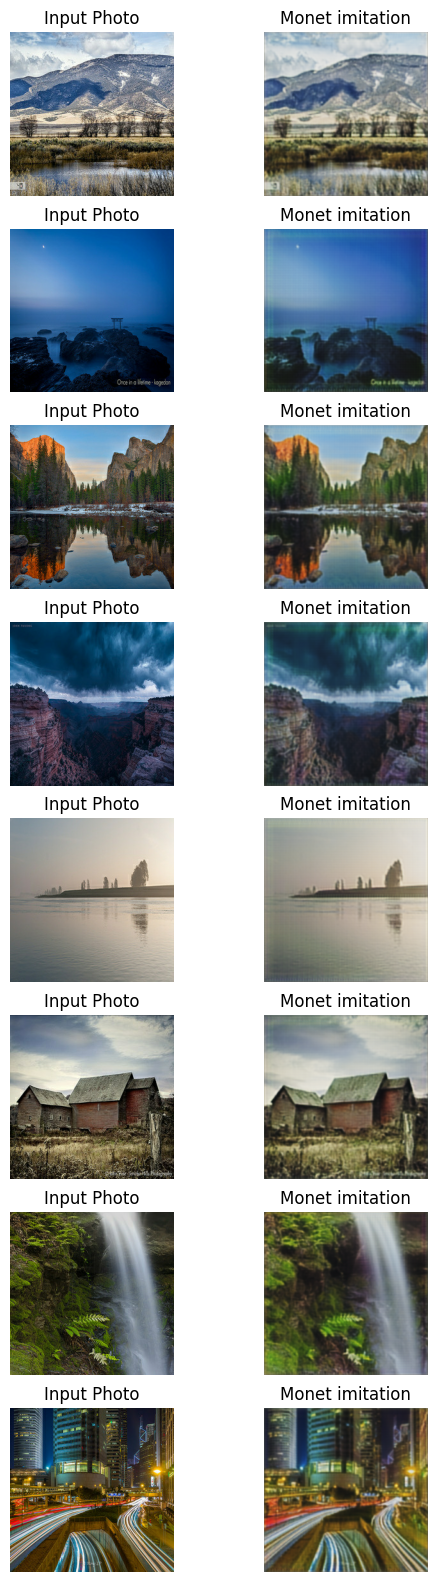

In [51]:
# Applying transfer leaning and observing performance for CycleGAN
_, axes = plt.subplots(8, 2, figsize=(6, 20))
for index, image in enumerate(photo_dataset.take(8)):
    generated_image = monet_generator(image, training=False)[0].numpy()
    generated_image = (generated_image * 127.5 + 127.5).astype(np.uint8)
    original_image = (image[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    axes[index, 0].imshow(original_image)
    axes[index, 1].imshow(generated_image)
    axes[index, 0].set_title("Input Photo")
    axes[index, 1].set_title("Monet imitation")
    axes[index, 0].axis("off")
    axes[index, 1].axis("off")
plt.show()


In the preceding section, I transformed the initial 8 images in the batch dataset into their Monet-style counterparts. Notably, some challenges were observed. While the model adeptly replicated Monet's style in the blue skies and performed well in conveying slightly blurred landscapes, it struggled in higher-contrast images and those with low contrast, as evident in the 5th 6th and 7th images.

The 4th image exhibited a relatively smaller color gamut overall, while the 8th one had a wider color gamut. The model encountered difficulty in effectively transferring Monet's style to both of these cases.

Before concluding the model evaluation, we will submit the results and obtain the MiFID metric. In this project, a smaller MiFID score indicates better-generated images.

In [52]:
import PIL
! mkdir ../images

In [53]:
counter = 1
for image in photo_dataset:
    generated_image = monet_generator(image, training=False)[0].numpy()
    generated_image = (generated_image * 127.5 + 127.5).astype(np.uint8)
    image_object = PIL.Image.fromarray(generated_image)
    image_object.save("../images/" + str(counter) + ".jpg")
    counter += 1
    print(f'counter: {counter}')


In [54]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'

# Conclusion

While I am impressed with this model, I think we could further enhance this score in the future by exploring more intricate CNN architectures and further fine-tuning of the CycleGAN. Nevertheless, embarking on the initial endeavor to train a CycleGAN and utilize it for style transfer, transforming non-Monet images into Monet-style creations, is an incredible experience in itself. This underscores the capabilities of AI even at a beginner level and highlights the strength of the community, which played a crucial role in facilitating our learning and hands-on practice with CycleGAN from the ground up.